In [779]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import re
from os import path
from glob import glob
from tqdm import tqdm
import numpy as np
from matplotlib import cm
from pprint import pprint
from plotting_utils import get_legend_name, remove_outliers

In [780]:
ROOT_PATH = '\\\\CILab_NAS_Data/homes/inchang/PuzzlePCG/ProxyPlayer'

In [781]:
files = glob(path.join(ROOT_PATH, '*', 'MatchResult_*.csv'))


In [782]:
StatisticsColumns = [
    'ReachedKnowledgeStep',
    'Matched_HorizontalPiece', 'Matched_VerticalPiece', 'Matched_CrossPiece', 'Matched_RocketPiece', 'Matched_BombPiece', 'Matched_RainbowPiece']

In [783]:
replacements = {
    'met': 'method',
    'pla': 'player',
    'eff': 'simpleEffect',
    'obj': 'objective',
    'sim': 'simulation',
    'rat': 'almostRatio',
    'pdep': 'playerDepth',
}

def parse_filename(data):
    result = dict()
    for i in range(0, len(data), 2):
        if data[i] in replacements.keys():
            data[i] = replacements[data[i]]

        result[data[i]] = data[i+1]

    return result

In [784]:
dfs = []
for file_path in tqdm(files):
    # print(file_path)
    file_name = path.basename(file_path)

    _file_name = file_name.split('_')[1:-1]
    args = parse_filename(_file_name)

    df = pd.read_csv(file_path)

    for key, value in args.items():
        df[key] = value
    dfs.append(df)

original_df = pd.concat(dfs)

original_df['Sum_Matched'] = original_df['Matched_HorizontalPiece'] + original_df['Matched_HorizontalPiece'] + original_df['Matched_HorizontalPiece']  + \
    original_df['Matched_HorizontalPiece'] + original_df['Matched_HorizontalPiece'] + original_df['Matched_HorizontalPiece']
original_df.loc[original_df['method'] == 'random', 'simulation'] = 0

original_df['simpleEffect'] = original_df['simpleEffect'].replace(np.nan, 0)
original_df['objective'] = original_df['objective'].replace(np.nan, '-')

original_df.loc[original_df['method'] == 'random', 'playerDepth'] = '-'
original_df.loc[original_df['method'] == 'sampling', 'playerDepth'] = '-'
original_df.loc[original_df['method'] == 'ga', 'playerDepth'] = '-'
original_df.loc[original_df['method'] == 'ga2', 'playerDepth'] = '-'
original_df.loc[original_df['method'] == 'random', 'simulation'] = '-'
original_df.loc[original_df['method'] == 'ga', 'simulation'] = '-'
original_df.loc[original_df['method'] == 'ga2', 'simulation'] = '-'
# original_df.loc[original_df['method'] == 'sampling', 'simulation'] = '-'
original_df.loc[original_df['method'] == 'random', 'almostRatio'] = '-'
original_df.loc[original_df['method'] == 'sampling', 'almostRatio'] = '-'
original_df.loc[original_df['method'] == 'ga', 'almostRatio'] = '-'
original_df.loc[original_df['objective'] == 'kp', 'almostRatio'] = '-'
original_df.loc[original_df['objective'] == 'score', 'almostRatio'] = '-'

100%|██████████| 275/275 [01:16<00:00,  3.60it/s]


In [785]:
original_df

,EpisodeCount,StepCount,Time,InstanceUUID,SettleCount,ChangedCount,MeanComparisonCount,StdComparisonCount,ReachedKnowledgeStep,Q1ReachedKnowledgeStep,...,Target_BombPiece,Target_RainbowPiece,method,player,simpleEffect,objective,simulation,almostRatio,playerDepth,Sum_Matched
0,1,200,2023-06-02 08:32:37.871,15e26aee,0,0,0.0,0.0,40,12,...,2,3,ga2,0,1,-,-,NaN,-,102
1,2,200,2023-06-02 08:43:52.551,15e26aee,0,0,0.0,0.0,27,27,...,2,3,ga2,0,1,-,-,NaN,-,234
2,3,200,2023-06-02 08:55:14.703,15e26aee,0,0,0.0,0.0,33,18,...,2,3,ga2,0,1,-,-,NaN,-,174
3,4,200,2023-06-02 09:06:38.685,15e26aee,0,0,0.0,0.0,35,18,...,2,3,ga2,0,1,-,-,NaN,-,126
4,5,200,2023-06-02 09:17:48.341,15e26aee,0,0,0.0,0.0,51,17,...,2,3,ga2,0,1,-,-,NaN,-,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,94,200,2023-06-02 01:23:14.468,66fe1046,0,0,0.0,0.0,105,53,...,4,5,sampling,9,1,-,30,-,-,270
94,95,200,2023-06-02 01:33:13.303,66fe1046,0,0,0.0,0.0,-1,-1,...,4,5,sampling,9,1,-,30,-,-,36
95,96,200,2023-06-02 01:42:56.172,66fe1046,0,0,0.0,0.0,-1,-1,...,4,5,sampling,9,1,-,30,-,-,0
96,97,200,2023-06-02 01:54:27.766,66fe1046,0,0,0.0,0.0,156,27,...,4,5,sampling,9,1,-,30,-,-,234


In [786]:
# 완료하지 못했을 경우, 에피소드 최대길이로 설정
original_df['ReachedKnowledgeStep'] = original_df['ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q1ReachedKnowledgeStep'] = original_df['Q1ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q2ReachedKnowledgeStep'] = original_df['Q2ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q3ReachedKnowledgeStep'] = original_df['Q3ReachedKnowledgeStep'].replace(-1, 200)


In [787]:
for i in range(5):
    original_df['playerDepth'] = original_df['playerDepth'].replace(str(i), i)
for i in range(100, 1000, 100):
    original_df['simulation'] = original_df['simulation'].replace(str(i), i)

In [788]:
match_result = original_df.groupby(['method', 'objective', 'playerDepth', 'simulation'])[
                                      'method',
                                      'Matched_HorizontalPiece',
                                      'Matched_VerticalPiece',
                                      'Matched_CrossPiece',
                                      'Matched_RocketPiece',
                                      'Matched_BombPiece',
                                      'Matched_RainbowPiece',
                                      #'AlmostReachedKnowledgeStep',
                                      'Q1ReachedKnowledgeStep',
                                      'Q2ReachedKnowledgeStep',
                                      'Q3ReachedKnowledgeStep',
                                      'ReachedKnowledgeStep',
                                      'Sum_Matched'].agg(
    {
        'method': ['count'],
     }
)
match_result




C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


method
                                           count
method   objective playerDepth simulation       
ga       -         -           -             761
ga2      -         -           -           16716
mcts     knowledge 1           100          5500
                               1000         5500
         score     1           100          5500
                               200          5500
                               1000         5500
                   2           100          5500
                               200          5500
                               1000         5500
                   3           100          5500
                               200          5500
                               1000         5500
random   -         -           -            5500
sampling -         -           10           3150
                               20           1621
                               30           1088

### Full Result

In [789]:
# Drop outliers
match_result = original_df.copy()

match_result = match_result[~match_result['almostRatio'].isin(['0.75'])]
# match_result = match_result[~match_result['playerDepth'].isin([2])]
# match_result = match_result[~match_result['simulation'].isin([100, 400])]



columns_to_remove_outliers = ['Q1ReachedKnowledgeStep',
                              'Q2ReachedKnowledgeStep',
                              'Q3ReachedKnowledgeStep',
                              'ReachedKnowledgeStep']

for column in columns_to_remove_outliers:
    match_result[column] = match_result.groupby(['method', 'simpleEffect', 'objective', 'playerDepth', 'simulation'])[column].transform(remove_outliers)
    match_result = match_result[match_result[column] != -9999]

match_result_noout = match_result.copy()

# print(set(match_result['playerDepth']))
# pd.set_option('display.max_rows', None)
match_result = match_result.groupby(['method', 'simpleEffect','objective', 'playerDepth', 'simulation'])[
                                      'method',
                                      'Matched_HorizontalPiece',
                                      'Matched_VerticalPiece',
                                      'Matched_CrossPiece',
                                      'Matched_RocketPiece',
                                      'Matched_BombPiece',
                                      'Matched_RainbowPiece',
                                      'Q1ReachedKnowledgeStep',
                                      'Q2ReachedKnowledgeStep',
                                      'Q3ReachedKnowledgeStep',
                                      'ReachedKnowledgeStep',
                                      'Sum_Matched'].agg(
    {
        'method': ['count']
     }
)
match_result


C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


method
                                                        count
method   simpleEffect objective playerDepth simulation       
ga       1            -         -           -             724
ga2      1            -         -           -           15853
mcts     1            knowledge 1           100          4929
                                            1000         5008
                      score     1           100          5225
                                            200          5262
                                            1000         5247
                                2           100          5242
                                            200          5241
                                            1000         5245
                                3           100          5216
                                            200          5244
                                            1000         5241
random   1            -         -           -            5500
sampling 1            -         -           10           3150
                                            20           1621
                                            30           1088

### Depth 1 Result

In [790]:
# Drop outliers
match_result = original_df.copy()

match_result = match_result[~match_result['almostRatio'].isin(['0.75'])]
match_result = match_result[~match_result['playerDepth'].isin([2, 3])]
match_result = match_result[~match_result['objective'].isin([2, 3])]
match_result = match_result[~match_result['simulation'].isin([200])]


columns_to_remove_outliers = ['Q1ReachedKnowledgeStep',
                              'Q2ReachedKnowledgeStep',
                              'Q3ReachedKnowledgeStep',
                              'ReachedKnowledgeStep']

for column in columns_to_remove_outliers:
    match_result[column] = match_result.groupby(['method', 'simpleEffect', 'objective', 'playerDepth', 'simulation'])[column].transform(remove_outliers)
    match_result = match_result[match_result[column] != -9999]

# print(set(match_result['playerDepth']))
# pd.set_option('display.max_rows', None)

match_result.rename(columns={
                            'ReachedKnowledgeStep': '100%',
                            'Q1ReachedKnowledgeStep': '25%',
                            'Q2ReachedKnowledgeStep': '50%',
                            'Q3ReachedKnowledgeStep': '75%'
                            }, inplace=True)


match_result = match_result.groupby(['method', 'objective', 'simulation'])[
                                      '25%',
                                      '50%',
                                      '75%',
                                      '100%',
                                      'Sum_Matched'].agg(
    {
        'Sum_Matched': ['mean',],
        '25%': ['mean'],
        '50%': ['mean'],
        '75%': ['mean'],
        '100%': ['mean'],
     }
)
match_result

C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Sum_Matched        25%        50%         75%  \
                                     mean       mean       mean        mean   
method   objective simulation                                                 
ga       -         -           184.831492  30.218232  35.867403   46.871547   
ga2      -         -           181.117643  33.072415  40.345928   52.921655   
mcts     knowledge 100         269.862447  37.812132  44.274295   56.042605   
                   1000        271.831869  35.491613  41.587859   52.259784   
         score     100         392.490718  44.179713  53.491675   70.750622   
                   1000        432.499714  40.485230  49.148847   64.378883   
random   -         -           235.380000  78.032909  93.037636  116.757455   
sampling -         10          223.455238  86.081905  98.342540  117.943492   
                   20          233.167181  76.301666  88.172733  107.942628   
                   30          245.338235  71.930147  84.822610  105.369485   

                                     100%  
                                     mean  
method   objective simulation              
ga       -         -            49.890884  
ga2      -         -            57.338800  
mcts     knowledge 100          59.901197  
                   1000         56.105431  
         score     100          76.427751  
                   1000         69.575376  
random   -         -           123.642000  
sampling -         10          124.089206  
                   20          114.196792  
                   30          110.974265

In [791]:
match_result.to_latex('match_count_table.tex', float_format="%.3f", escape=True)


In [792]:
display_graphs = ['random', 'ga',
                  'sampling_20',
                   'mcts_knowledge_1.0_1000_1',
                   'mcts_score_1000_1']

{'ga',
 'ga2',
 'mcts_knowledge_1.0_1000_1',
 'mcts_knowledge_1.0_100_1',
 'mcts_score_1000_1',
 'mcts_score_1000_2',
 'mcts_score_1000_3',
 'mcts_score_100_1',
 'mcts_score_100_2',
 'mcts_score_100_3',
 'mcts_score_200_1',
 'mcts_score_200_2',
 'mcts_score_200_3',
 'random',
 'sampling_10',
 'sampling_20',
 'sampling_30'}


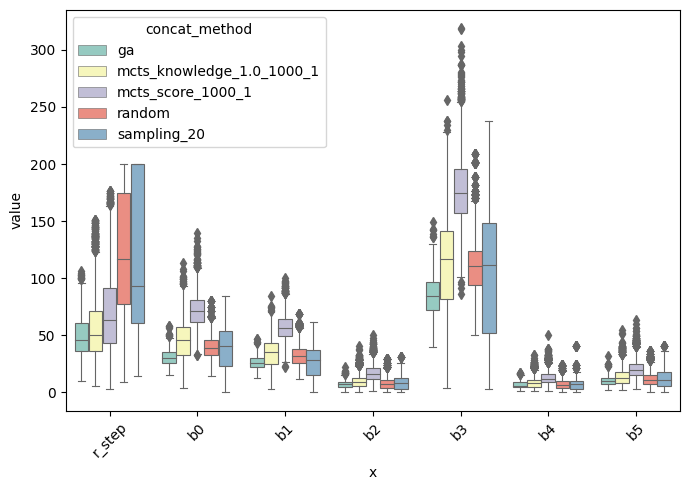

In [793]:
melted_df = match_result_noout.copy()

melted_df['concat_method'] = melted_df.agg(lambda x: get_legend_name(x), axis=1)
pprint(set(melted_df['concat_method']))
# Display Target
melted_df = melted_df[melted_df['concat_method'].isin(['random', 'ga',
                                                       'sampling_20',
                                                       'mcts_knowledge_1.0_1000_1',
                                                       'mcts_score_1000_1'])]

plt.figure(figsize=(7, 5))
melted_df = pd.melt(melted_df, id_vars=['EpisodeCount', 'objective', 'concat_method', 'simulation', 'player'],
                    value_vars=[*StatisticsColumns], ignore_index=False)

melted_df['x'] = melted_df['variable']
melted_df['x'] = melted_df['x'].str.replace('ReachedKnowledgeStep', 'r_step')
melted_df['x'] = melted_df['x'].str.replace('Matched_HorizontalPiece', 'b0')
melted_df['x'] = melted_df['x'].str.replace('Matched_VerticalPiece', 'b1')
melted_df['x'] = melted_df['x'].str.replace('Matched_CrossPiece', 'b2')
melted_df['x'] = melted_df['x'].str.replace('Matched_RocketPiece', 'b3')
melted_df['x'] = melted_df['x'].str.replace('Matched_BombPiece', 'b4')
melted_df['x'] = melted_df['x'].str.replace('Matched_RainbowPiece', 'b5')

ax = sns.boxplot(x="x", y="value", hue="concat_method", data=melted_df, linewidth=0.8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('matched_block.png')

In [794]:
from statannot import add_stat_annotation
from itertools import combinations

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

75_random v.s. 75_sampling_20: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.250e+00
100_random v.s. 100_sampling_20: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.371e+00
50_mcts_score_1000_1 v.s. 50_random: t-test independent samples with Bonferroni correction, P_val=7.112e-33 stat=-1.268e+01
75_mcts_knowledge_1.0_1000_1 v.s. 75_mcts_score_1000_1: t-test independent samples with Bonferroni correction, P_val=1.315e-12 stat=-7.633e+00
25_mcts_score_1000_1 v.s. 25_random: t-test independent samples with Bonferroni correction, P_val=8.868e-31 stat=-1.223e+01
25_mcts_knowledge_1.0_1000_1 v.s. 25_mcts_score_1000_1: t-test independent samples with Bonferroni correction, P_val=7.186e-01 stat=-2.174e+00
25_random v.s. 25_sampling_20: t-test independent samples with Bon

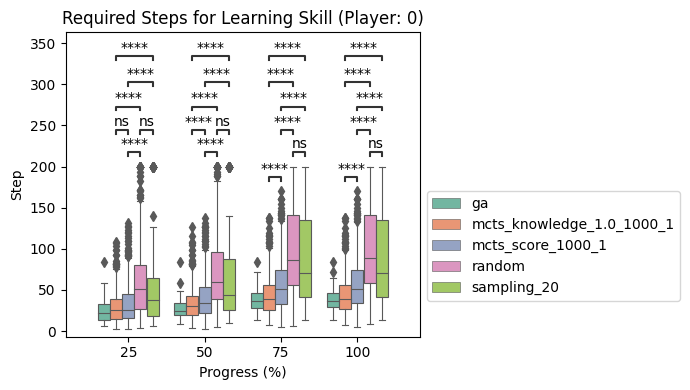

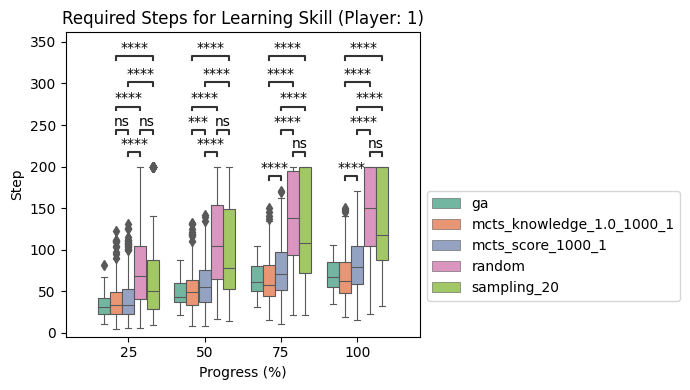

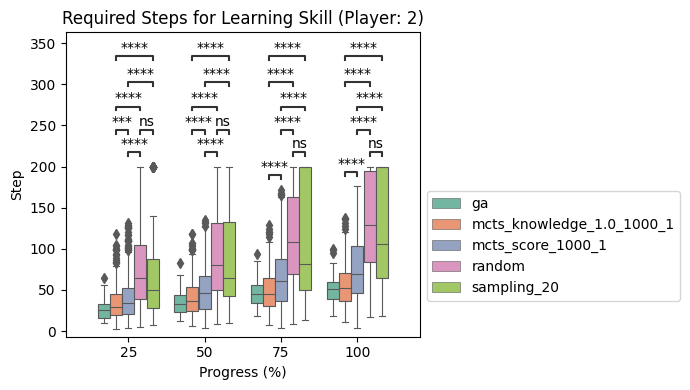

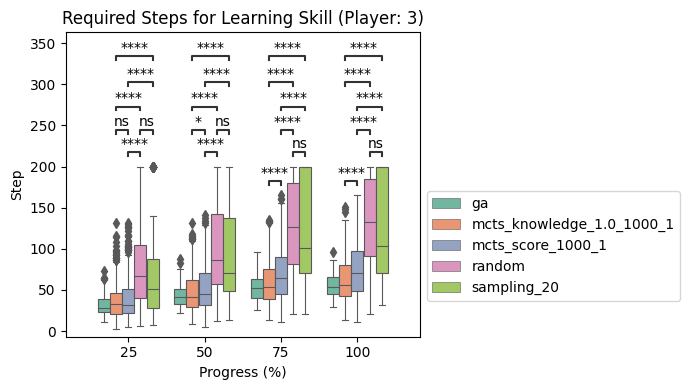

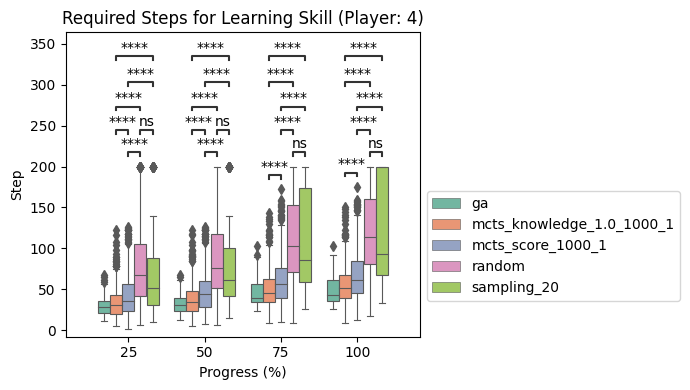

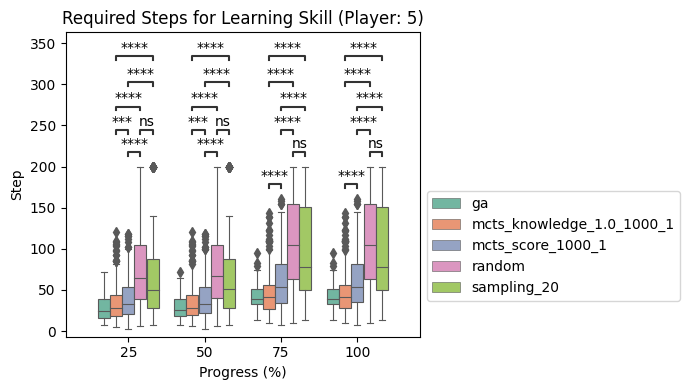

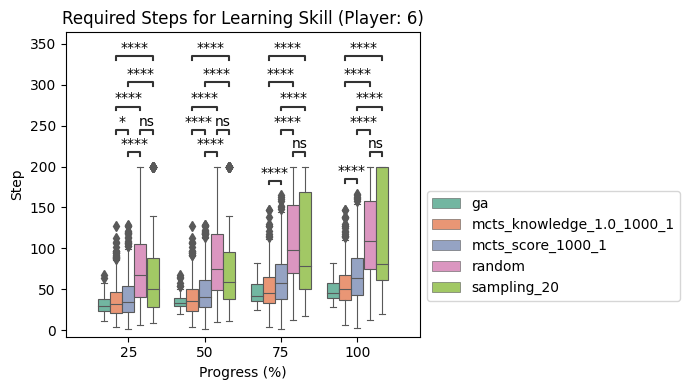

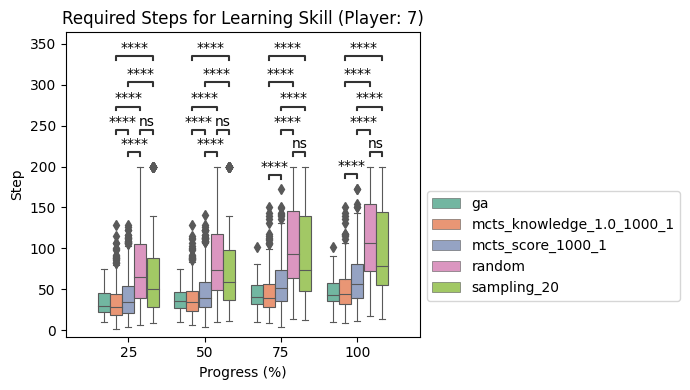

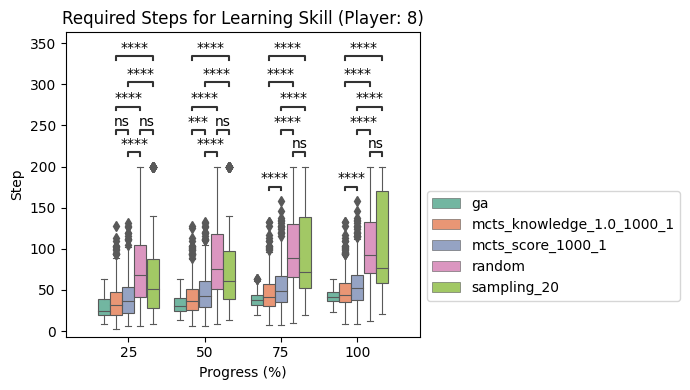

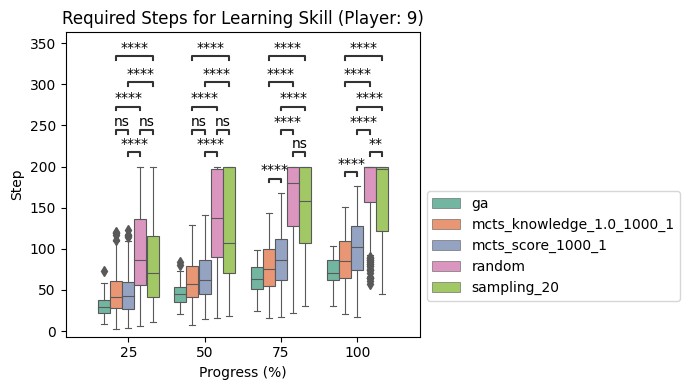

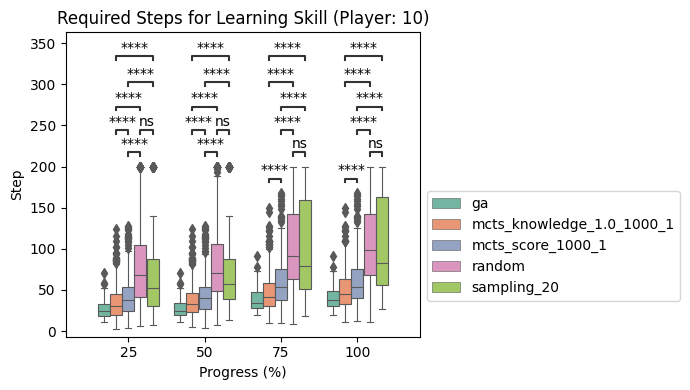

In [795]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  for player_no in range(0, 11):
player_df = match_result_noout[match_result_noout['player'] == str(player_no)]
melted_df = player_df.copy()

melted_df.rename(columns={
    'ReachedKnowledgeStep':'100',
    'Q1ReachedKnowledgeStep':'25',
    'Q2ReachedKnowledgeStep':'50',
    'Q3ReachedKnowledgeStep':'75'
}, inplace=True)

_columns = ['25', '50', '75', '100']

sns.set_palette('Set2')
# melted_df = melted_df.groupby(['player', 'method', 'objective', 'playerDepth', 'simulation']).sample(n=300, random_state=1)
melted_df['concat_method'] = melted_df.agg(lambda x: get_legend_name(x), axis=1)
melted_df = pd.melt(melted_df, id_vars=['EpisodeCount', 'objective', 'concat_method', 'simulation', 'player'], value_vars=[*_columns], ignore_index=False)

melted_df = melted_df[melted_df['concat_method'].isin(display_graphs)]

plt.figure(figsize=(7, 4))
plt.clf()
ax = sns.boxplot(x="variable", y="value", hue="concat_method", data=melted_df, dodge=True, linewidth=0.8)

pairs = list()
for i in range(25, 101, 25):
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'mcts_score_1000_1')))
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'random')))
    pairs.append(((str(i), 'random'), (str(i), 'mcts_score_1000_1')))
    pairs.append(((str(i), 'random'), (str(i), 'sampling_20')))
    pairs.append(((str(i), 'mcts_score_1000_1'), (str(i), 'sampling_20')))
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'sampling_20')))

add_stat_annotation(ax, x="variable", y="value", hue="concat_method", data=melted_df,
                    box_pairs=pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=1)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
ax.set_title(f'Required Steps for Learning Skill (Player: {player_no})')
ax.set_xlabel('Progress (%)')
ax.set_ylabel('Step')
plt.tight_layout()
plt.savefig(f'./figures/learning_steps_p{player_no}', dpi=300)
    # plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

75_random v.s. 75_sampling_20: t-test independent samples with Bonferroni correction, P_val=1.036e-06 stat=5.483e+00
100_random v.s. 100_sampling_20: t-test independent samples with Bonferroni correction, P_val=6.934e-08 stat=5.945e+00
50_mcts_score_1000_1 v.s. 50_random: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=-5.338e+01
75_mcts_knowledge_1.0_1000_1 v.s. 75_mcts_score_1000_1: t-test independent samples with Bonferroni correction, P_val=1.023e-92 stat=-2.079e+01
25_mcts_score_1000_1 v.s. 25_random: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=-4.925e+01
25_mcts_knowledge_1.0_1000_1 v.s. 25_mcts_score_1000_1: t-test independent samples with Bonferroni correction, P_val=2.648e-26 stat=-1.094e+01
25_random v.s. 25_sampling_20: t-test independent samples with Bon

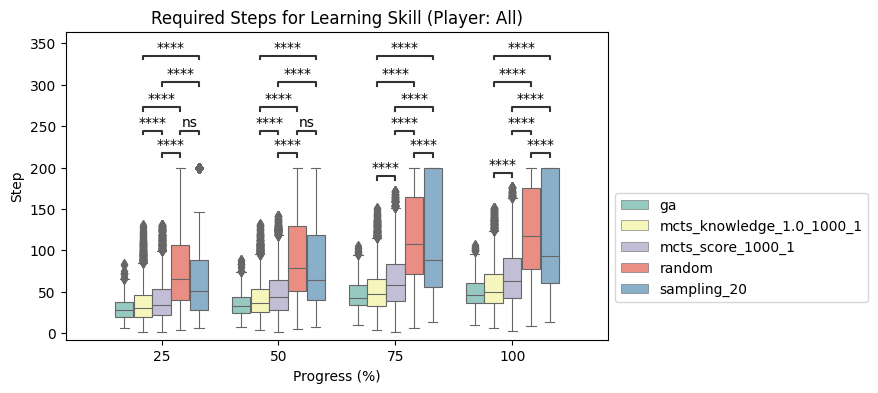

In [796]:

melted_df = match_result_noout.copy()

melted_df.rename(columns={
    'ReachedKnowledgeStep':'100',
    'Q1ReachedKnowledgeStep':'25',
    'Q2ReachedKnowledgeStep':'50',
    'Q3ReachedKnowledgeStep':'75'
}, inplace=True)

_columns = ['25', '50', '75', '100']

sns.set_palette('Set3')
# melted_df = melted_df.groupby(['player', 'method', 'objective', 'playerDepth', 'simulation']).sample(n=300, random_state=1)
melted_df['concat_method'] = melted_df.agg(lambda x: get_legend_name(x), axis=1)
melted_df = pd.melt(melted_df, id_vars=['EpisodeCount', 'objective', 'concat_method', 'simulation', 'player'], value_vars=[*_columns], ignore_index=False)

melted_df = melted_df[melted_df['concat_method'].isin(display_graphs)]


plt.figure(figsize=(7, 4))
plt.clf()
ax = sns.boxplot(x="variable", y="value", hue="concat_method", data=melted_df, dodge=True, linewidth=0.8)

pairs = list()
for i in range(25, 101, 25):
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'mcts_score_1000_1')))
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'random')))
    pairs.append(((str(i), 'random'), (str(i), 'mcts_score_1000_1')))
    pairs.append(((str(i), 'random'), (str(i), 'sampling_20')))
    pairs.append(((str(i), 'mcts_score_1000_1'), (str(i), 'sampling_20')))
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'sampling_20')))

add_stat_annotation(ax, x="variable", y="value", hue="concat_method", data=melted_df,
                    box_pairs=pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=1)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
ax.set_title(f'Required Steps for Learning Skill (Player: All)')
ax.set_xlabel('Progress (%)')
ax.set_ylabel('Step')
plt.savefig(f'./figures/learning_steps_pA', dpi=300)
# plt.show()